Trying to directly predict whether a model should be rejected using BCE loss performs less well than predicting CLs and choosing some small CLs cutoff.

There are 1842 total models in test set.
346 are invalid (have a true CLs less than 0.05).
Removing all models with predicted CLs of less than 3.5e-5 (0.000035) removes 174 models including 18 valid models.

Thus we remove 45% of invalid models whilst removing ~1% of valid models.
From another point of view, for every 10 models we remove, only 1 is valid and should have been saved.

Another way to look at it - if the CERN supercomputers would have done a year of number-crunching, that would normally include more than 2 months of crunching wasted on invalid models. Using my model first, we could cut that wasted time by over a month! (Specifically, 2.25 months -> 1.24 months.)

The predictor is CLs_predictor_4l_128n_75epoch_MAE.keras

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

output_df = pd.read_csv("csv-files/CLs_predictions/4l_128n_75e_0.005lr_MAE_with_all_data.csv")
output_df.head()

,Unnamed: 0,Model_number,FullHad__ExpCLs,FullHad__ObsCLs,FullHad__level,1Lbb__ExpCLs,1Lbb__ObsCLs,1Lbb__level,2L0J__ExpCLs,2L0J__ObsCLs,...,Truth_ntuple,ML_input,Truth_ntuple__FILTER,DSID,AOD,PRW,EVNT,SLHA,SH_SLHA,Predicted_Final__CLs
0,859,859,1.000,1.0000,Truth,1.000,1.000,Truth,0.946,0.939,...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,NaN,-1,NaN,NaN,NaN,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,9.496799e-01
1,5269,5269,1.000,1.0000,Filtered,1.000,1.000,Filtered,1.000,1.000,...,NaN,NaN,NaN,-1,NaN,NaN,NaN,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,9.999763e-01
2,1403,1403,1.000,1.0000,Filtered,1.000,1.000,Filtered,1.000,1.000,...,NaN,NaN,NaN,-1,NaN,NaN,NaN,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,1.000000e+00
3,2451,2451,0.640,0.4630,Truth,0.749,0.799,Truth,0.970,0.967,...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,NaN,-1,NaN,NaN,NaN,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,5.382919e-01
4,7723,7723,0.193,0.0849,Truth,0.799,0.832,Truth,0.879,0.892,...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,-1,NaN,NaN,NaN,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,/eos/atlas/atlascerngroupdisk/phys-susy/pMSSM/...,2.809671e-08


In [16]:
def plot_number_of_models_by_bins_of_m_chi_10(df, num_bins):
    
    m_chi_10 = df["m_chi_10"]
    predicted_valid_models = df["Predicted_Final__CLs"] > 0.05
    
    # Create bins
    bins = np.linspace(0, 1000, num_bins + 1)
    
    # Compute number of models for each bin
    number_of_models_by_bin = []
    allowed_models_by_bin = []
    
    bin_centers = []
    
    for i in range(num_bins):
        # Find indices of values in this bin
        bin_mask = (m_chi_10 >= bins[i]) & (m_chi_10 < bins[i+1])
        valid_bin_mask = bin_mask & predicted_valid_models
        
        # Calculate number of models for this bin
        number_of_models = bin_mask.sum()
        num_valid_models = valid_bin_mask.sum()
        
        # We only have 15% of the original dataset as we trained on the first 85%. Rescale to original to make a fair comparison
        scaled_number_of_models = number_of_models / 0.15
        scaled_num_of_valid_models = num_valid_models / 0.15
        number_of_models_by_bin.append(scaled_number_of_models)
        allowed_models_by_bin.append(scaled_num_of_valid_models)
        bin_centers.append((bins[i] + bins[i+1]) / 2)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, number_of_models_by_bin, width=(bins[1]-bins[0])*0.9, color="gray")
    plt.bar(bin_centers, allowed_models_by_bin, width=(bins[1]-bins[0])*0.9)
    
    plt.title('Number of models by m_chi_10 bins')
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('Number of models')
    plt.grid(axis='y', linestyle='--')
    
    plt.tight_layout()
    #plt.savefig("plots/CLs_predictor_performance/recreate_figure_4b.pdf")
    
    return plt.gcf(), plt.gca()

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='m_chi_10 [GeV]', ylabel='Number of models'>)

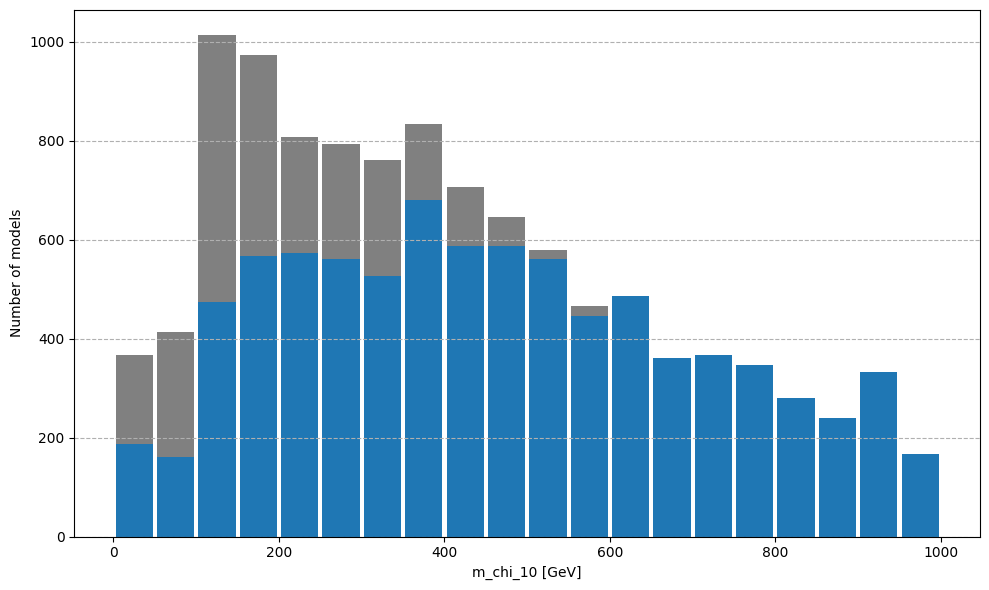

In [17]:
plot_number_of_models_by_bins_of_m_chi_10(output_df, 20)

In [3]:
# Separate predictions and targets into separate arrays
predictions = output_df["Predictions"].values
targets = output_df["Targets"].values

# Print MAE and absolute mean of targets
print(f"MAE: {(np.abs(predictions-targets)).mean()}")
print(f"Absolute mean of targets: {(np.abs(targets)).mean()}")

MAE: 0.14869589011497694
Absolute mean of targets: 0.8105320304017373


In [ ]:
def plot_rejections_by_cutoff(true_values, predicted_values, num_points=100, x_range=1):

    # Calculate which models should be rejected (CLs < 0.05, which also selects Is_Valid == 0)
    true_cutoff = 0.05
    target_rejections = true_values < true_cutoff
    correct_accepted = np.logical_not(target_rejections)
    
    # Create array of test cutoffs
    test_cutoffs = np.linspace(0,x_range,num=num_points)
 
    # Create array of incorrect rejection
    incorrect_rejections = []
    total_rejections = []

    for cutoff in test_cutoffs:

        # Calculate which predictions are rejected by chosen cutoff
        rejected_predictions = predicted_values < cutoff
        
        # Calculate fraction of models that should have been accepted but were rejected
        total_wrongly_rejected = (rejected_predictions > target_rejections).sum()
        fraction_wrongly_rejected = total_wrongly_rejected / correct_accepted.sum()
        
        # Calculate fraction of all models rejected
        fraction_rejeceted = rejected_predictions.sum() / len(true_values)
        
        # Store these values for plotting
        incorrect_rejections.append(fraction_wrongly_rejected)
        total_rejections.append(fraction_rejeceted)
    
    # Plot fraction of rejected models against cutoff
    plt.figure(figsize=(8, 6))
    plt.plot(test_cutoffs, incorrect_rejections)
    plt.plot(test_cutoffs, total_rejections)
    plt.axhline(0.01, color="red")
    plt.xlabel("Confidence cutoff")
    plt.ylabel("Fraction of models")
    plt.grid(axis='y', linestyle='--')
    plt.legend(["Fraction of valid models wrongly rejected (lower is better)", "Fraction of total models rejected (higher is better)"])
    plt.title("Fraction of models rejected against confidence cutoff")
    
    #plt.savefig("plots/Is_Valid_predictor_performance/4l_64n_19e_BCE_loss_rejected_models_against_confidence_cutoff.png")
    plt.show()

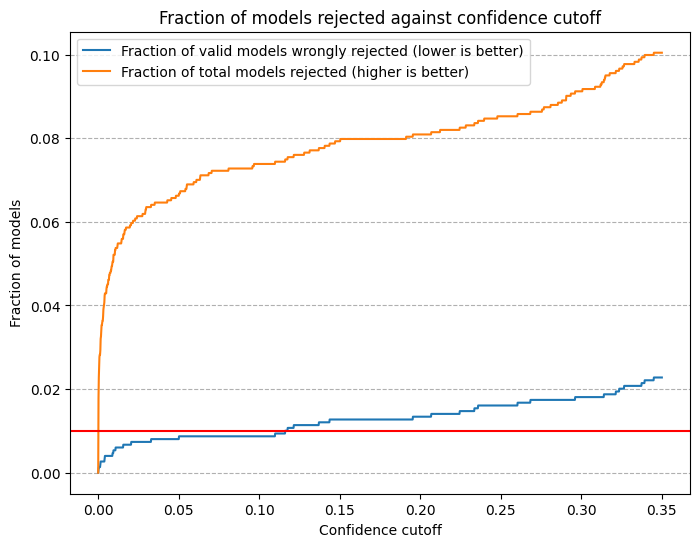

In [36]:
plot_rejections_by_cutoff(targets, predictions, len(targets), 0.35)

In [66]:
def plot_mae_by_bins(true_values, predicted_values, num_bins):
    
    # Calculate absolute errors
    abs_errors = np.abs(true_values - predicted_values)
    
    # Create bins
    bins = np.linspace(true_values.min(), true_values.max(), num_bins + 1)
    
    # Compute mean absolute error for each bin
    mae_by_bin = []
    bin_centers = []
    
    for i in range(num_bins):
        # Find indices of values in this bin. Unnecessary given targets are sorted 
        bin_mask = (true_values >= bins[i]) & (true_values < bins[i+1])
        
        # Calculate MAE for this bin
        if np.sum(bin_mask) > 0:
            mae = np.mean(abs_errors[bin_mask])
            mae_by_bin.append(mae)
            bin_centers.append((bins[i] + bins[i+1]) / 2)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, mae_by_bin, width=(bins[1]-bins[0])*0.9)
    
    plt.title('Mean Absolute Error by CLs Bins')
    plt.xlabel('True Relic Density (normalised log scale)')
    plt.ylabel('Mean Absolute Error')
    plt.grid(axis='y', linestyle='--')
    
    # Add mae values on top of each bar
    for i, mae in enumerate(mae_by_bin):
        plt.text(bin_centers[i], mae, f'{mae:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    #plt.savefig("plots/CLs_predictor_performance/MAE_in_bins_backward_sigmoid.png")
    
    return plt.gcf(), plt.gca()

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Mean Absolute Error by CLs Bins'}, xlabel='True Relic Density (normalised log scale)', ylabel='Mean Absolute Error'>)

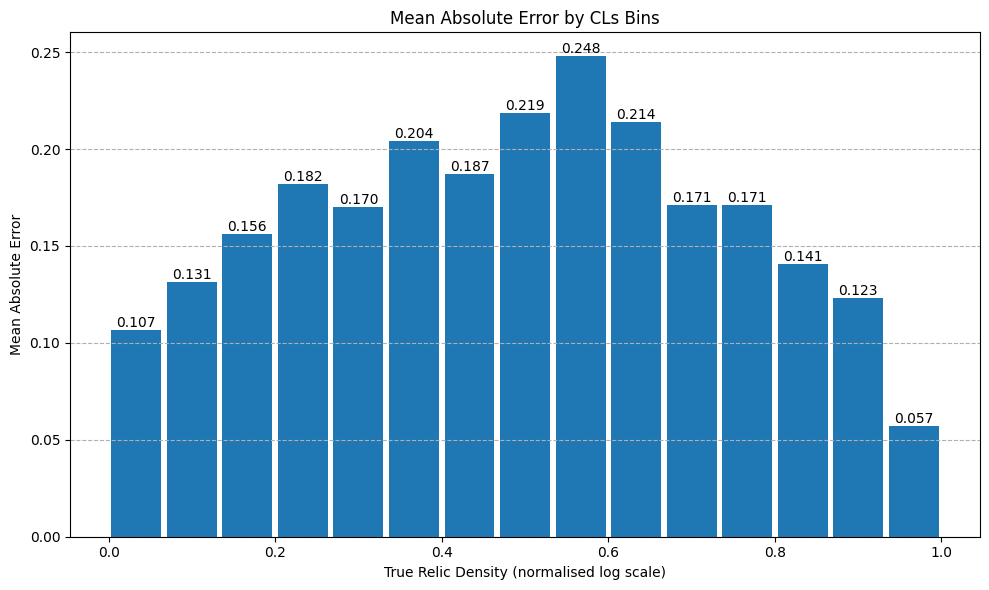

In [67]:
plot_mae_by_bins(targets, predictions, 15)

In [26]:
# Create dataframe of wrongly rejected models, for which predicted CLs < 3.5e-5 and true CLs > 0.05
comparison_df = input_df
comparison_df["Predictions"] = predictions
pred_reject = comparison_df["Predictions"] < 3.5e-5
target_reject = comparison_df["Final__CLs"] < 0.05
incorrectly_rejected_models = comparison_df.loc[pred_reject > target_reject]

# Create dataframe of correctly rejected models
correctly_predicted_models = comparison_df.loc[pred_reject == target_reject]
correctly_rejected_models = correctly_predicted_models.loc[pred_reject == True]
len(correctly_rejected_models)

156

In [ ]:
# Create array of column names to label plot of parameter means
col_names = []
for col in input_df.columns:
    col_names.append(col)
col_names = col_names[0:-2]
print(col_names)

['M_1', 'M_2', 'mu', 'tan_beta', 'M_3', 'At', 'Ab', 'Atau', 'mA', 'mqL3', 'mtR', 'mbR']


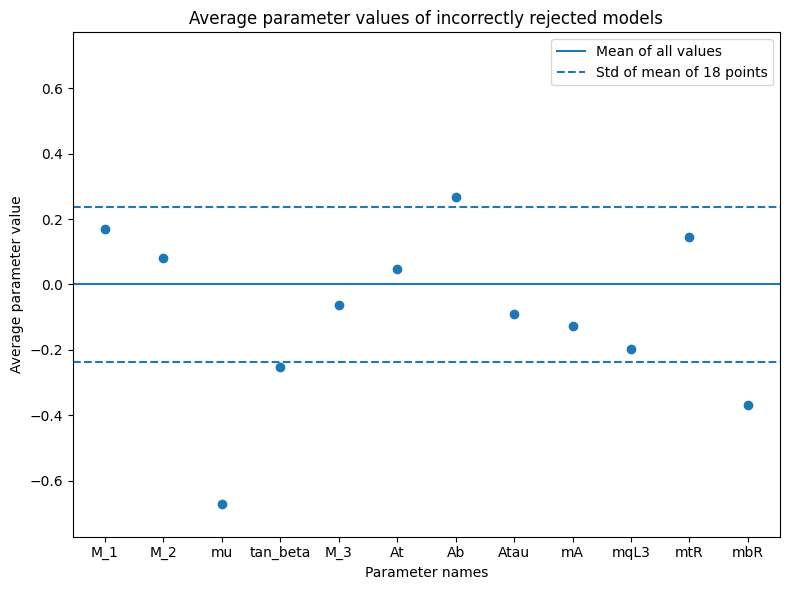

In [ ]:
# Extract average of each parameter for correctly rejected models
col_avg = correctly_rejected_models.mean(axis=0).values
num_models = len(correctly_rejected_models)

# Remove predictions and targets
col_avg = col_avg[0:-2]

# Plot column averages against column number
plt.figure(figsize=(8,6))
plt.axhline(0)
std_of_mean = 1/np.sqrt(num_models)
plt.axhline(std_of_mean, linestyle="--")
plt.axhline(-std_of_mean, linestyle="--")
y_lim = max(abs(col_avg)) + 0.1
plt.ylim(top=y_lim, bottom=-y_lim)
plt.title("Average parameter values of correctly rejected models")
plt.xlabel("Parameter names")
plt.ylabel("Average parameter value")
plt.legend(["Mean of all values", "Std of mean of 156 points"])
plt.scatter(col_names, col_avg)

plt.tight_layout()
#plt.savefig("plots/CLs_predictor_performance/right_prediction_parameter_averages.pdf")
plt.show()

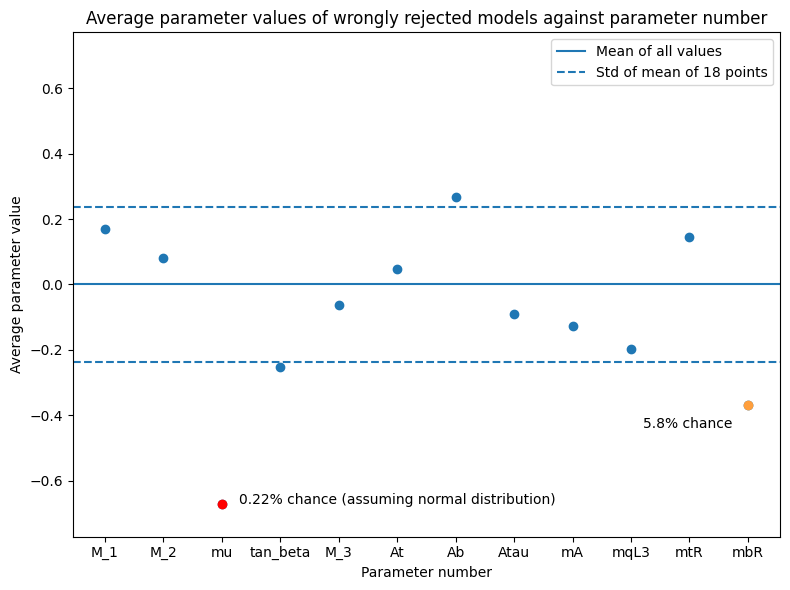

In [ ]:
# Extract average of each parameter for incorrectly rejected models
col_avg = incorrectly_rejected_models.mean(axis=0).values

# Remove predictions and targets
col_avg = col_avg[0:-2]

# Plot column averages against column number, highlighting outliers
plt.figure(figsize=(8,6))
plt.axhline(0)
std_of_mean = 1/np.sqrt(18)
plt.axhline(std_of_mean, linestyle="--")
plt.axhline(-std_of_mean, linestyle="--")
y_lim = max(abs(col_avg)) + 0.1
plt.ylim(top=y_lim, bottom=-y_lim)
plt.title("Average parameter values of wrongly rejected models against parameter number")
plt.xlabel("Parameter number")
plt.ylabel("Average parameter value")
plt.legend(["Mean of all values", "Std of mean of 18 points"])
plt.scatter(col_names, col_avg)

plt.text(2+0.3,col_avg[2],"0.22% chance (assuming normal distribution)")
plt.scatter(2,col_avg[2],c="r")

plt.text(9.2, col_avg[11]-0.07, "5.8% chance")
plt.scatter(11,col_avg[11],c="#ff9f3d")

plt.tight_layout()
#plt.savefig("plots/CLs_predictor_performance/wrong_prediction_parameter_averages.pdf")
plt.show()

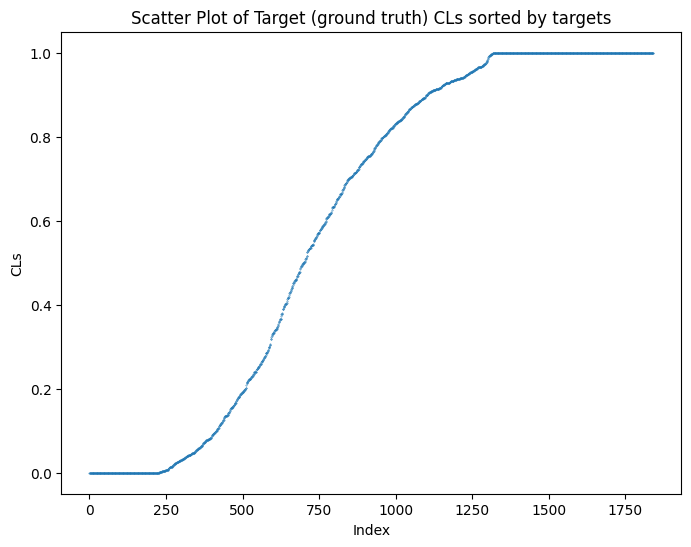

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(targets)), targets, s=0.1)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("CLs")
plt.title(f"Scatter Plot of Target (ground truth) CLs sorted by targets")

# Save the plot
# plt.savefig(f"plots/DM_predictor_performance/DM-targets.png")

# Show the plot
plt.show()

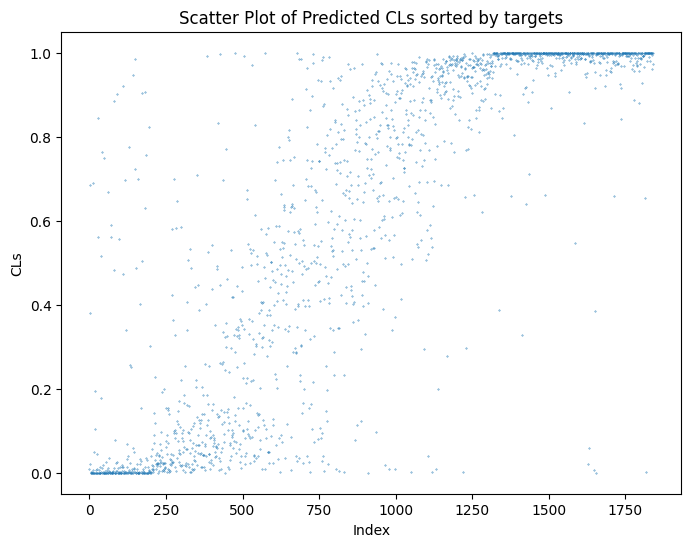

In [69]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(predictions)), predictions, s=0.1)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("CLs")
plt.title(f"Scatter Plot of Predicted CLs sorted by targets")

# Save the plot
# plt.savefig(f"plots/DM_predictor_performance/DM-predictions.png")

# Show the plot
plt.show()